This notebook will make composite figures of all cases in each convective mode. 

In [1]:
#Supress Warnings
import warnings
warnings.filterwarnings("ignore")

from utils import integral_ts

import numpy as np
import pickle
import cmocean
from datetime import datetime
import scipy.signal as sig
from scipy.ndimage import gaussian_filter
import pandas as pd
from scipy import signal,stats
import scipy.integrate as si

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,AutoMinorLocator
import matplotlib.dates as mdates

#Import the case dictionaries
f = open('clamps_cases.pckl', 'rb')
lin,dis,mix = pickle.load(f)
f.close()

l_height = 2500 #m
l_height_barb = 1500 #m 2500

plt.rcParams.update({'font.size':30,'font.family':'Arial'})


In [2]:
#Print out all case dates to pick the index
data = lin
print('Linear')
[print('{}: {}'.format(k,data[k]['date'])) for k in range(len(data))]
print()

data = dis
print('Discrete')
[print('{}: {}'.format(k,data[k]['date'])) for k in range(len(data))]
print()

data = mix
print('Mixed')
[print('{}: {}'.format(k,data[k]['date'])) for k in range(len(data))]
print()

Linear
0: 2017-03-10 06:45:00
1: 2017-03-28 03:35:00

Discrete
0: 2017-03-27 20:16:00
1: 2017-04-05 23:39:00
2: 2019-04-07 22:05:00
3: 2016-04-01 00:45:00
4: 2016-04-30 21:15:00

Mixed
0: 2017-03-01 19:55:00
1: 2017-03-21 22:15:00
2: 2017-03-27 22:35:00
3: 2017-04-22 22:25:00
4: 2019-03-09 20:25:00



In [8]:
#######################################################
#Start with compositing the integral time scales
#######################################################
var_name = 'Theta'
data_var = 'theta'
time_var = 't_utc'
hght_var = 't_height'

#Index the height to a specified level
h1 = np.where(lin[0][hght_var]>=1500)[0][0]

lin_ave_qv = np.nanmedian(np.array([integral_ts(lin[i][data_var],(lin[i][time_var] - lin[i][time_var][0])/3600,lin[i][hght_var][:h1])[0] for i in range(len(lin))]),axis=0)
dis_ave_qv = np.nanmedian(np.array([integral_ts(dis[i][data_var],(dis[i][time_var] - dis[i][time_var][0])/3600,dis[i][hght_var][:h1])[0] for i in range(len(dis))]),axis=0)
mix_ave_qv = np.nanmedian(np.array([integral_ts(mix[i][data_var],(mix[i][time_var] - mix[i][time_var][0])/3600,mix[i][hght_var][:h1])[0] for i in range(len(mix))]),axis=0)

#Get the height values for plotting (should be the same height values across cases)
hght = lin[0][hght_var][:h1]



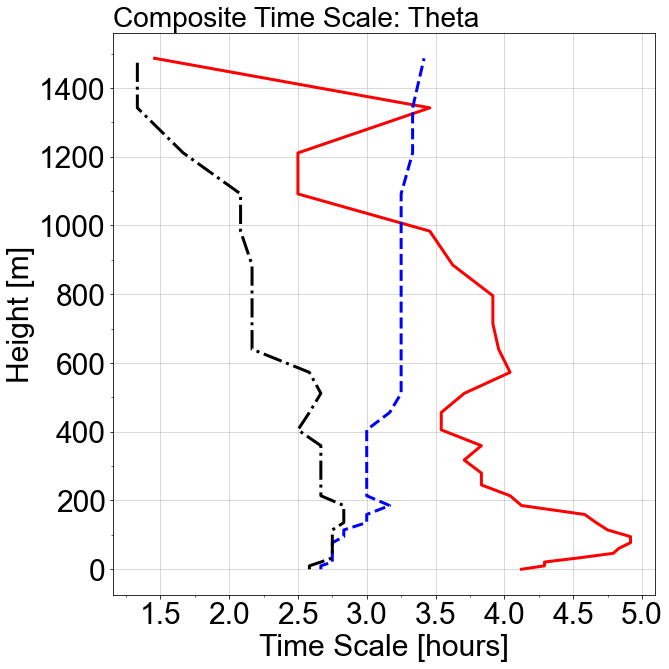

In [6]:
plt.figure(figsize=(10,10))
plt.grid(alpha=0.6)
ax = plt.subplot(1,1,1)
ax.set_title(r'Composite Time Scale: {}'.format(var_name),loc='left',size=28)
#Plot qv
ax.plot(lin_ave_qv,hght,color='red',label='Linear Mode',linewidth=3,linestyle='solid')
ax.plot(dis_ave_qv,hght,color='blue',label='Discrete Mode',linewidth=3,linestyle='dashed')
ax.plot(mix_ave_qv,hght,color='k',label='Mixed Mode',linewidth=3,linestyle='dashdot')

#Format axes
ax.set_ylabel('Height [m]')
ax.yaxis.set_major_locator(MultipleLocator(200))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(100))
#ax.set_ylim([0,1500])


ax.set_xlabel('Time Scale [hours]')
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
#ax.set_xlim([0,6])
#legend
#ax.legend(framealpha=0.0,loc='upper right',fontsize=18)

plt.tight_layout()
#plt.savefig('figures/composites/time_scales_cape.jpg',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

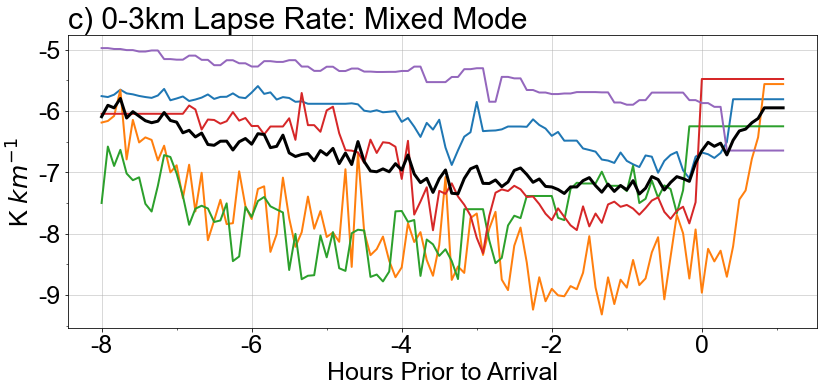

In [13]:
#######################################################
#0-3km lapse rate composites
#######################################################

#Bin the temporal resolution
delta_t = 5/60
times = np.arange(-8,1+delta_t,delta_t)

#Compute the lapse rate at binned time steps
def lr_compute(data,tidx):
    return np.array([(data[i]['temp'][tidx[i],np.where(data[i]['t_height']>=3000)[0][0]] - data[i]['temp'][tidx[i],0])/((data[i]['t_height'][np.where(data[i]['t_height']>=3000)[0][0]]-data[i]['t_height'][0])/1000) for i in range(len(data))])

#Set up the figure
plt.rcParams.update({'font.size':25,'font.family':'Arial'})
plt.figure(figsize=(12,6))
ax = plt.subplot(1,1,1)
plt.grid(alpha=0.6)
plt.title('c) 0-3km Lapse Rate: Mixed Mode',loc='left')

#Linear mode
data = mix
tidx = [np.array([np.where(data[i]['t_rel']>=val)[0][0] for val in times]) for i in range(len(data))]
lr = lr_compute(data,tidx)
[ax.plot(times,lr[i,:],linewidth=2) for i in range(len(data))]
ax.plot(times,np.nanmean(lr,axis=0),color='k',linewidth=3,label='Average')

#Format the axes
ax.set_ylabel('K $km^{-1}$')
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set_xlabel('Hours Prior to Arrival')
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.legend(framealpha=0.0,loc='upper left',fontsize=18)

plt.tight_layout()
#plt.savefig('figures/composites/mixed_LR.jpg',dpi=300,bbox_inches='tight')
plt.show()
plt.close()


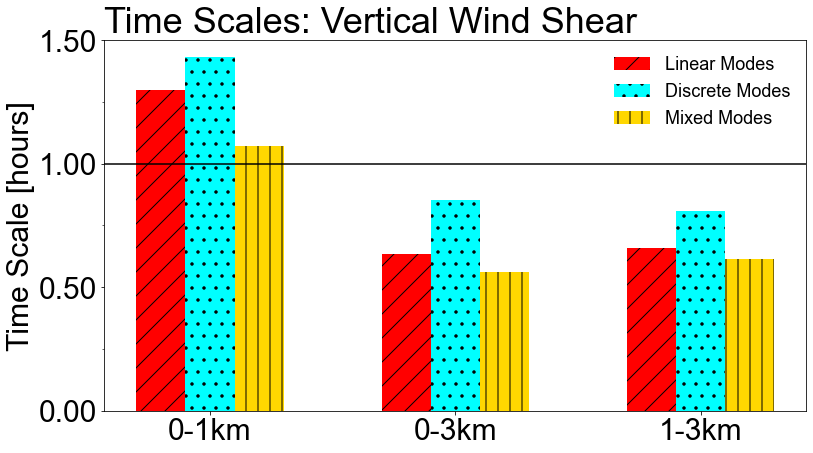

In [10]:
#######################################################
#Make a bar chart of wind shear time scales
#######################################################

h1 = np.where(lin[0]['t_height']>=1500)[0][0]

#Compute the shear time scales
lin01 = np.nanmedian(np.array([integral_ts(lin[i]['mag01'],(lin[i]['l_utc'] - lin[i]['l_utc'][0])/3600,lin[i]['l_height'][:h1])[0] for i in range(len(lin))]),axis=0)
dis01 = np.nanmedian(np.array([integral_ts(dis[i]['mag01'],(dis[i]['l_utc'] - dis[i]['l_utc'][0])/3600,dis[i]['l_height'][:h1])[0] for i in range(len(dis))]),axis=0)
mix01 = np.nanmedian(np.array([integral_ts(mix[i]['mag01'],(mix[i]['l_utc'] - mix[i]['l_utc'][0])/3600,mix[i]['l_height'][:h1])[0] for i in range(len(mix))]),axis=0)

lin03 = np.nanmedian(np.array([integral_ts(lin[i]['mag03'],(lin[i]['l_utc'] - lin[i]['l_utc'][0])/3600,lin[i]['l_height'][:h1])[0] for i in range(len(lin))]),axis=0)
dis03 = np.nanmedian(np.array([integral_ts(dis[i]['mag03'],(dis[i]['l_utc'] - dis[i]['l_utc'][0])/3600,dis[i]['l_height'][:h1])[0] for i in range(len(dis))]),axis=0)
mix03 = np.nanmedian(np.array([integral_ts(mix[i]['mag03'],(mix[i]['l_utc'] - mix[i]['l_utc'][0])/3600,mix[i]['l_height'][:h1])[0] for i in range(len(mix))]),axis=0)

lin13 = np.nanmedian(np.array([integral_ts(lin[i]['mag13'],(lin[i]['l_utc'] - lin[i]['l_utc'][0])/3600,lin[i]['l_height'][:h1])[0] for i in range(len(lin))]),axis=0)
dis13 = np.nanmedian(np.array([integral_ts(dis[i]['mag13'],(dis[i]['l_utc'] - dis[i]['l_utc'][0])/3600,dis[i]['l_height'][:h1])[0] for i in range(len(dis))]),axis=0)
mix13 = np.nanmedian(np.array([integral_ts(mix[i]['mag13'],(mix[i]['l_utc'] - mix[i]['l_utc'][0])/3600,mix[i]['l_height'][:h1])[0] for i in range(len(mix))]),axis=0)



#Plot the bar chart
labels = ['0-1km','0-3km','1-3km']

fig = plt.figure(figsize=(12,7))
ax = plt.subplot(1,1,1)
plt.title('Time Scales: Vertical Wind Shear',loc='left')
x = np.arange(len(labels)) 
width = 0.2

#Plot the data
linb = [lin01,lin03,lin13]
disb = [dis01,dis03,dis13]
mixb = [mix01,mix03,mix13]

ax.bar(x-width, linb, width, label='Linear Modes',color='red',hatch='/')
ax.bar(x, disb, width, label='Discrete Modes',color='cyan',hatch='.')
ax.bar(x+width, mixb, width, label='Mixed Modes',color='gold',hatch='|')

ax.axhline(y=1,color='k')

#Format the axes
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(framealpha=0.0,loc='upper right',fontsize=18)

#Format the tick lines
ax.set_ylabel('Time Scale [hours]')
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

plt.tight_layout()
#plt.savefig('figures/composites/vws.jpg',dpi=300,bbox_inches='tight')
plt.show()

